# Advanced Tutorial 10: Automated Report Generation

## Overview
In this tutorial, we will discuss:
* [Overview and Dependencies](#ta10od)
* [Traceability](#ta10t)
* [Test Report](#ta10tr)

## Preliminary Setup

Let's get some imports and object construction out of the way:

In [1]:
import tempfile
import os
import numpy as np
import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy

root_output_dir = tempfile.mkdtemp()

def get_estimator(extra_traces):
    # step 1
    train_data, eval_data = mnist.load_data()
    test_data = eval_data.split(100)
    test_data['id'] = [i for i in range(len(test_data))]  # Assign some data ids for the test report to look at
    pipeline = fe.Pipeline(train_data=train_data,
                           eval_data=eval_data,
                           test_data=test_data,
                           batch_size=32,
                           ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

    # step 2
    model = fe.build(model_fn=LeNet, optimizer_fn="adam")
    network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce")
    ])
    # step 3
    traces = [
        Accuracy(true_key="y", pred_key="y_pred"),
        BestModelSaver(model=model, save_dir=root_output_dir, metric="accuracy", save_best_mode="max"),
        LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=3750, init_lr=1e-3))
    ]
    traces.extend(extra_traces)
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=2,
                             traces=traces,
                             max_train_steps_per_epoch=100,
                             max_eval_steps_per_epoch=100,
                             log_steps=10)
    return estimator

<a id='ta10od'></a>

## Overview and Dependencies
FastEstimator provides Traces which allow you to automatically generate traceability documents and test reports. These reports are written in the LaTeX file format, and then automatically compiled into PDF documents if you have LaTeX installed on your machine. If you don't have LaTeX installed on your training machine, you can still generate the report files and then move them to a different computer in order to compile them manually. Generating traceability documents also requires GraphViz which, unlike LaTeX, must be installed in order for training to proceed. 

```
Installing Dependencies:
    On Linux: 
        apt-get install -y graphviz texlive-latex-base texlive-latex-extra
    On SageMaker:
        unset PYTHONPATH
        export DEBIAN_FRONTEND=noninteractive
        apt-get install -y graphviz texlive-latex-base texlive-latex-extra
    On Mac:
        brew install graphviz
        brew cask install mactex
    On Windows:
        winget install graphviz
        winget install TeXLive
```

<a id='ta10t'></a>

## Traceability
Traceability reports are designed to capture all the information about the state of your system when an experiment was run. The report will include training graphs, operator architecture diagrams, model architecture diagrams, a summary of your system configuration, and the values of all variables used to instantiate objects during training. It will also automatically save a copy of your log output to disk, which can be especially useful for comparing different experiment configurations without worrying about forgetting what settings were used for each run. To generate this report, simply add a Traceability trace to your list of traces:

In [2]:
from fastestimator.trace.io import Traceability

save_dir = os.path.join(root_output_dir, 'report')
est = get_estimator([Traceability(save_dir)])

print(f"The root save directory is: {root_output_dir}")
print(f"The traceability report will be written to: {save_dir}")
print(f"Logs and images from the report will be written to: {os.path.join(save_dir, 'resources')}")

The root save directory is: /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpivnaimp0
The traceability report will be written to: /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpivnaimp0/report
Logs and images from the report will be written to: /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpivnaimp0/report/resources


When using Traceability, you must pass a summary name to the Estimator.fit() call. This will become the name of your report.

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; num_device: 0; logging_interval: 10; 
FastEstimator-Train: step: 1; ce: 2.31206; model_lr: 0.0009999998; 
FastEstimator-Train: step: 10; ce: 2.1062746; steps/sec: 116.49; model_lr: 0.0009999825; 
FastEstimator-Train: step: 20; ce: 1.4076996; steps/sec: 127.78; model_lr: 0.0009999298; 
FastEstimator-Train: step: 30; ce: 0.7637405; steps/sec: 149.59; model_lr: 0.0009998423; 
FastEstimator-Train: step: 40; ce: 0.73430604; steps/sec: 151.84; model_lr: 0.0009997196; 
FastEstimator-Train: step: 50; ce: 0.40525973; steps/sec: 155.37

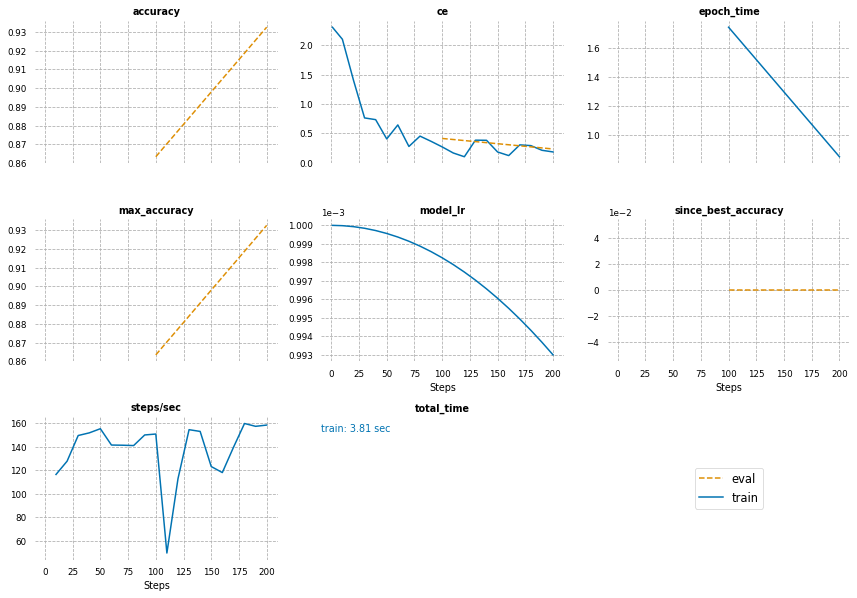

In [3]:
est.fit("Sample MNIST Report")

If everything went according to plan, then inside your root save directory you should now have the following files:

```
/report
    sample_mnist_report.pdf
    sample_mnist_report.tex
    /resources
        sample_mnist_report_logs.png
        sample_mnist_report_model.pdf
        sample_mnist_report.txt
```

You could then switch up your experiment parameters and call .fit() with a new experiment name in order to write more reports into the same folder. A call to `fastestimator logs ./resources` would then allow you to easily compare these experiments, as described in [Advanced Tutorial 6](./t06_summary.ipynb)

Our report should look something like this (use Chrome or Firefox to view):

In [4]:
from IPython.display import IFrame
IFrame('../resources/t10a_traceability.pdf', width=600, height=800)

<a id='ta10tr'></a>

## Test Report
Test Reports can provide an automatically generated overview summary of how well your model is performing. This could be useful if, for example, you needed to submit documentation to a regulatory agency. Test Reports can also be used to highlight particular failure cases so that you can investigate problematic data points in more detail.

The `TestReport` trace takes a list of `TestCase` objects as input. These are further subdivided into two types: aggregate and per-instance. Aggregate test cases run at the end of the test epoch and deal with aggregated information (typically metrics such as accuracy). Per-instance tests run at the end of every step during training, and are meant to evaluate every element within a batch independently. If your data dictionary happens to contain data instance ids, you can also use these to find problematic inputs. 

In [5]:
from fastestimator.trace.io.test_report import TestCase, TestReport

save_dir = os.path.join(root_output_dir, 'report2')

# Note that the name of the input to the 'criteria' function must match a key in the data dictionary
agg_test_easy = TestCase(description='Accuracy should be greater than 1%', criteria=lambda accuracy: accuracy > 0.01)
agg_test_hard = TestCase(description='Accuracy should be greater than 99%', criteria=lambda accuracy: accuracy > 0.99)

inst_test_hard = TestCase(description='All Data should be correctly classified', criteria=lambda y, y_pred: np.equal(y,np.argmax(y_pred, axis=-1)), aggregate=False, fail_threshold=0)
inst_test_easy = TestCase(description='At least one image should be correctly classified', criteria=lambda y, y_pred: np.equal(y,np.argmax(y_pred, axis=-1)), aggregate=False, fail_threshold=len(est.pipeline.data['test'])-1)

report = TestReport(test_cases=[agg_test_easy, agg_test_hard, inst_test_easy, inst_test_hard], save_path=save_dir, data_id='id')

est = get_estimator([report])

print(f"The root save directory is: {root_output_dir}")
print(f"The test report will be written to: {save_dir}")
print(f"A json summary of the report will be written to: {os.path.join(save_dir, 'resources')}")

The root save directory is: /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpivnaimp0
The test report will be written to: /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpivnaimp0/report2
A json summary of the report will be written to: /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpivnaimp0/report2/resources


In [6]:
est.fit("MNIST")
est.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; num_device: 0; logging_interval: 10; 
FastEstimator-Train: step: 1; ce: 2.302236; model1_lr: 0.0009999998; 
FastEstimator-Train: step: 10; ce: 2.146747; steps/sec: 79.15; model1_lr: 0.0009999825; 
FastEstimator-Train: step: 20; ce: 1.5397147; steps/sec: 112.98; model1_lr: 0.0009999298; 
FastEstimator-Train: step: 30; ce: 1.1191428; steps/sec: 149.46; model1_lr: 0.0009998423; 
FastEstimator-Train: step: 40; ce: 0.59645134; steps/sec: 153.94; model1_lr: 0.0009997196; 
FastEstimator-Train: step: 50; ce: 0.5683198; steps/sec: 140

If everything went according to plan, then inside your root save directory you should now have the following files:

```
/report2
    mnist_TestReport.pdf
    mnist_TestReport.tex
    /resources
        mnist_TestReport.json
```

Our report should look something like this (use Chrome or Firefox to view):

In [7]:
from IPython.display import IFrame
IFrame('../resources/t10a_test.pdf', width=600, height=800)